<a href="https://colab.research.google.com/github/andrewbowen19/mastersThesisData698/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [305]:
%pip install --q torch_geometric
%pip install --q torcheval
%pip install --q captum

In [306]:
import torch_geometric
import pandas as pd
from pandas import DataFrame
import numpy as np
import networkx as nx
import torch
from torch_geometric.data import HeteroData


import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import random


from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Setting seeds for reproducing
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

## Data Cleaning
There's some basic data cleaning we'll perform on our datasets. All datasets are available as CSV files on the [CEDR Database Website](https://oriseapps.orau.gov/cedr/) (with an application submitted).

In [307]:
class DataCleaner(object):
  """Class to perform basic cleaning on data read-in from each site

  Attributes:
    None

  Methods:
    snake_case_columns: Convert all columns in a pandas DataFrame to `snake_case`
    trim_whitespace: Trim all leading and trailing whitespace
  """
  def __init__(self):
    pass

  @staticmethod
  def snake_case_columns(df: DataFrame) -> DataFrame:
    """Convert all columns in a pandas DataFrame to `snake_case`"""
    new_cols = [c.lower().replace(" ", "_").replace("-", "_") for c in df.columns]

    df.columns = new_cols
    return df

  @staticmethod
  def trim_whitespace(df: DataFrame) -> DataFrame:
    """Trim all leading and trailing whitespace"""
    for c in df.columns:
      if isinstance(df.dtypes[c], np.dtypes.ObjectDType):
        df[c] = df[c].str.strip()
    return df

  @staticmethod
  def insert_century(date_str: str):
    """Insert "19" into the date string; as all data is 20th century"""
    # Split the date string into components
    month, day, year = date_str.split('/')
    # Insert "19" at the beginning of the year component
    year = '19' + year
    # Join the components back into a date string
    return '/'.join([month, day, year])

  @staticmethod
  def date_parser(df: DataFrame, column_name: str, format: str = "%m/%d/%y") -> DataFrame:
    """Parse date-like columns in a dataframe"""
    df[column_name] = pd.to_datetime(df[column_name], format=format, infer_datetime_format=True)#, century_first=50)
    return df


  @staticmethod
  def replace_value(df: DataFrame, column_name: str, old:str, new:str) -> DataFrame:
    """Replace a value in a column. Will be used to map SRP -> SRS"""

    df[column_name] = df[column_name].str.replace(old, new)
    return df

  @staticmethod
  def assign_id_column(df: DataFrame, data_type: str) -> DataFrame:
    """Use row index (attributable to seq_no in CEDR datasets)"""

    df[f'{data_type}_id'] = df.reset_index().index.values
    return df


cleaner = DataCleaner()


We'll combine all datasets of a given type (*Building*, *Chemical Agent*) into a single dataset that can later be partitioned by site.

In [308]:
# Map site names to their ID/Code values
site_mapping = {
    "Hanford Site": {"code": "HANF",
                     "filename_prefix": "Hanford",
                     "site_code": 91},
    "Los Alamos National Laboratory": {"code": "LANL",
                     "filename_prefix": "LANL", "site_code": 52},
    "Savannah River Site": {"code": "SRS",
                     "filename_prefix": "SRS", "site_code": 22},
    "Oak Ridge National Laboratory": {"code": "ORNL",
                     "filename_prefix": "ORNL", "site_code": 7},
}

data_types = ["Buildings", "ChemicalAgents", "IH"]


def construct_df(data_type: str = "Buildings"):
  dfs = []
  for site, info in site_mapping.items():
    prefix = info.get("filename_prefix")
    filename = f"/content/{prefix}-{data_type}.csv"

    dat = pd.read_csv(filename, na_values = "")
    dfs.append(dat)


  df = pd.concat(dfs)

  return df

# Read in datasets and combine across sites for each data type
buildings = construct_df("Buildings")
agents = construct_df("ChemicalAgents")
ih_data = construct_df("IH")

In [309]:
# Do some basic data cleaning/preprocessing

# snake_case columns
buildings = cleaner.snake_case_columns(buildings)
agents = cleaner.snake_case_columns(agents)
ih_data = cleaner.snake_case_columns(ih_data)


# Trim whitespace
buildings = cleaner.trim_whitespace(buildings)
agents = cleaner.trim_whitespace(agents)
ih_data = cleaner.trim_whitespace(ih_data)

# Cast dates: need to coerce dates to 1900s
ih_data['date'] = ih_data['date'].apply(cleaner.insert_century)
# ih_data = cleaner.date_parser(ih_data, "date")
ih_data.head()

,agent,date,dep_grp,descript,facility,jobtitle,location,quantity,referenc,room,sampleid,site,type,uom,seq_no
0,mercury,12/22/1981,100N,"06686:Mercury survey lift station; n=1, airbor...",HANF,,,0.010000,HEX78_83,,122281_001,,BZ,mg/m3,1
1,benzene,4/24/1981,1100,06200:Personnel sampling of gas station attend...,HANF,623,,0.058000,HEX78_83,,042481_001,,BZ,ppm,2
2,benzene,7/30/1981,1100,06200:Personnel sampling of gas station attend...,HANF,623,,0.125000,HEX78_83,,073081_001,,BZ,ppm,3
3,benzene,7/31/1981,1100,06200:Personnel and breathing zone samples of ...,HANF,623,,0.030000,HEX78_83,,073181_001,,BZ,ppm,4
4,formaldehyde,9/1/1981,1100,06476:Impinger samples collected between 1100 ...,HANF,HO5,,0.195000,HEX78_83,,090181_001,,BZ,ppm,5


### Case Control

The datasets below contain some features related to a given employee, as well as ICD Cause of death codes

In [310]:
# Reading in death cause codes (ICD-8)
icd = pd.read_csv("/content/icd8.csv")
icd = cleaner.snake_case_columns(icd)
icd = cleaner.trim_whitespace(icd)

# Case control data from CEDR
case_control = pd.read_csv("/content/wing-case-control-DOE.csv")
case_control = cleaner.snake_case_columns(case_control)#.head()
case_control = cleaner.trim_whitespace(case_control)

# Update multiple myeloma code to match ICD dataset
case_control['ca81'] = case_control['ca81'].str.replace("X", "")

# Lookup underlying cause of death
case_control = case_control.merge(icd[['code', 'disease']], left_on="ca81", right_on="code", how="left")
case_control.head()

,ca81,ca82,cancerhx,case,caseid,caseset,id,clas_chg,deny_job,dlo,...,sex,sitein,siteout,smoking,srp,vs,zia,seq_no,code,disease
0,,,0,0,83584,67,22524,9,0,01JUL1990,...,F,15MAY1945,15AUG1945,9,.,A,.,1,NaN,NaN
1,199,,0,0,66894,5,40324,9,0,01JUL1968,...,M,15APR1944,15SEP1945,9,.,DC,.,2,199,Malignant neoplasm without specification of site
2,199,,0,0,66894,5,40324,9,0,01JUL1968,...,M,15APR1944,15SEP1945,9,.,DC,.,2,199,Multiple
3,,,0,1,40577,38,40577,9,0,01JUL1971,...,M,15AUG1946,15OCT1948,1,.,DC,.,3,NaN,NaN
4,,,0,0,42315,29,42002,0,0,01JUL1970,...,M,15FEB1947,15APR1947,1,.,DC,.,4,NaN,NaN


In [311]:
# Fill in missing values for case control
case_control['disease'] = case_control['disease'].fillna("No disease")

In [312]:
# Check imbalance in case control cause of death codes
case_control.groupby('disease', dropna=False)['disease'].count().sort_values(ascending=False)

disease
No disease                                          473
Multiple myeloma                                     12
Malignant neoplasm without specification of site      2
Multiple                                              2
Bladder specified as secondary                        1
Malignant neoplasm of prostate                        1
Other secondary malignant neoplasm                    1
Name: disease, dtype: int64

### Sites

We have 4 sites in the *Wing et al., 2000* study. These are assigned facility codes within CEDR, which we'll preserve here as the index for our site nodes. Those codes are listed below:


- Los Alamos National Laboratory (LANL): 52
- Hanford Site (HANF): 91
- Savannah River Site (SRS): 22
- Oak Ridge National Laboratory (ORNL): 7



In [313]:
# Read in site dosimetry data
site_rad = pd.read_csv("/content/site-external-radiation.csv")

site_rad = cleaner.snake_case_columns(site_rad)
site_rad = cleaner.trim_whitespace(site_rad)


site_rad = site_rad.loc[site_rad['facility']!=""]

site_rad['wbd_1'] = site_rad['wbd_1'].str.replace(".", "0").fillna(0).astype(int)
site_rad['facility'] = site_rad['facility'].astype(int)

wbd_by_site = site_rad.groupby("facility")['wbd_1'].mean().reset_index()
wbd_by_site['facility'] = wbd_by_site['facility'].astype(int)
wbd_by_site

,facility,wbd_1
0,7,192.319149
1,22,196.624700
2,52,312.895105
3,91,329.029444


In [314]:
# Construct dataframe of sites in our study
sites_df = pd.DataFrame(site_mapping).T
sites_df = sites_df.reset_index()
sites_df['site_id'] = sites_df.index.to_numpy(dtype=int)

sites_df = sites_df.merge(wbd_by_site, how="left", left_on="site_id", right_index=True)

# Create tensor representing sites - using codes as our index
sites = torch.tensor(data=sites_df[['site_id', 'wbd_1']].values.tolist(), dtype=torch.long)
sites_df.head()

,index,code,filename_prefix,site_code,site_id,facility,wbd_1
0,Hanford Site,HANF,Hanford,91,0,7,192.319149
1,Los Alamos National Laboratory,LANL,LANL,52,1,22,196.624700
2,Savannah River Site,SRS,SRS,22,2,52,312.895105
3,Oak Ridge National Laboratory,ORNL,ORNL,7,3,91,329.029444


### Buidings

- Map `facility` to a site code

In [315]:
from sklearn.preprocessing import StandardScaler

buildings['facility'] = buildings['facility'].str.replace("SRP", "SRS").str.replace("ZIA", "LANL")
buildings = cleaner.assign_id_column(buildings, "building")
buildings['date'] = pd.to_datetime(buildings['date']).astype(int)

buildings['age'] = StandardScaler().fit_transform(buildings['date'].values.reshape(-1, 1))


# Lookup site number for each building
buildings = buildings.merge(sites_df[['code', "site_id"]],
                            how="left",
                            left_on="facility", right_on="code").drop("code", axis=1)

buildings.head()

<ipython-input-315-6d8fda15fef7>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  buildings['date'] = pd.to_datetime(buildings['date']).astype(int)


,begdate,date,facility,location,locinfo,referenc,seq_no,building_id,age,site_id
0,,189216000000000000,HANF,101-H,Deactivated 100-H Area bldg,H186,1,0,-0.828015,0
1,,189216000000000000,HANF,102-H,Deactivated 100-H Area bldg,H186,2,1,-0.828015,0
2,,189216000000000000,HANF,103-B,Fuel element storage,H186,3,2,-0.828015,0
3,,189216000000000000,HANF,103-D,Fuel element storage,H186,4,3,-0.828015,0
4,,189216000000000000,HANF,103-F,Storage (100-F),H186,5,4,-0.828015,0


## Industrial Hygiene data

This data helps us to identify the *presence* of given chemical agents within a site (and in some instances, the specific building/location) at that site.

In [316]:
# Replace old site/facility codes to match standard values
ih_data['facility'] = ih_data['facility'].str.replace("SRP", "SRS").str.replace("ZIA", "LANL")
ih_data['agent'] = ih_data['agent'].str.lower()

ih_data['quantity'] = ih_data['quantity'].str.replace("", "0").astype(float)

# Lookup site number for each agent
ih_data = ih_data.merge(sites_df[['code', "site_code", "site_id"]],
                            how="left",
                            left_on="facility", right_on="code").drop("code", axis=1)

ih_data.head()

,agent,date,dep_grp,descript,facility,jobtitle,location,quantity,referenc,room,sampleid,site,type,uom,seq_no,site_code,site_id
0,mercury,12/22/1981,100N,"06686:Mercury survey lift station; n=1, airbor...",HANF,,,0.000100,HEX78_83,,122281_001,,BZ,mg/m3,1,91,0
1,benzene,4/24/1981,1100,06200:Personnel sampling of gas station attend...,HANF,623,,0.000508,HEX78_83,,042481_001,,BZ,ppm,2,91,0
2,benzene,7/30/1981,1100,06200:Personnel sampling of gas station attend...,HANF,623,,0.010205,HEX78_83,,073081_001,,BZ,ppm,3,91,0
3,benzene,7/31/1981,1100,06200:Personnel and breathing zone samples of ...,HANF,623,,0.000300,HEX78_83,,073181_001,,BZ,ppm,4,91,0
4,formaldehyde,9/1/1981,1100,06476:Impinger samples collected between 1100 ...,HANF,HO5,,0.010905,HEX78_83,,090181_001,,BZ,ppm,5,91,0


#### Chemical Agent Node Features

We need to encode our chemical agent features to numeric values for model training downstream. We can leverage `scikit-learn`'s ColumnTransformer with a `OneHotEncoder` for each feature column in our IH data chemical agent columns. This should result in an array of shape (`n_agnets`, `n_encoded_features`).

In [317]:
# First, construct chemical agent node features from IH data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ih_data['date'] = pd.to_datetime(ih_data['date']).astype(int)

agent_cols = ["agent",
              "dep_grp",
              "descript",
              "facility",
              "jobtitle",
              "location",
              "room",
              "type",
              "uom"]

continuous_agent_cols = ["date", "quantity"]
ct = ColumnTransformer(
        [("ohe", OneHotEncoder(), agent_cols),
         ("scaler", StandardScaler(), continuous_agent_cols)])

chemical_features = ct.fit_transform(ih_data)
chemical_features = chemical_features.toarray()

# Print out dimensions of agent node features
chemical_features.shape

(3397, 4660)

### IH Data Edge Indices
There's three edge indices for chemical agents that we care about

1. Agent Presence at a **Site** (inferred for those with null `location` values)
2. Agent Presence at a **Building** (via `location` column)
3. \*Employee exposure to an agent (this is handled in **Exposure Records**)

#### Agent <> Site Edge Index

In [318]:
# Now construct Agent => Site Index based on columns
ih_data["seq_no"] = ih_data["seq_no"].astype(int)
ih_data["site_id"] = ih_data["site_id"].astype(int)
agent_site_edge_index = torch.tensor(ih_data[["seq_no", "site_id"]].values.transpose().tolist(), dtype=torch.long)

#### Agent <> Building Edge Index

This may be a bit more sparse, as precise location information is null/not present for most agents listed in out IH data

In [319]:
# Lookup building ID
ih_data = ih_data.merge(buildings[['location', 'building_id']], how='left', on="location")
ih_data.head()

,agent,date,dep_grp,descript,facility,jobtitle,location,quantity,referenc,room,sampleid,site,type,uom,seq_no,site_code,site_id,building_id
0,mercury,377827200000000000,100N,"06686:Mercury survey lift station; n=1, airbor...",HANF,,,0.000100,HEX78_83,,122281_001,,BZ,mg/m3,1,91,0,NaN
1,benzene,356918400000000000,1100,06200:Personnel sampling of gas station attend...,HANF,623,,0.000508,HEX78_83,,042481_001,,BZ,ppm,2,91,0,NaN
2,benzene,365299200000000000,1100,06200:Personnel sampling of gas station attend...,HANF,623,,0.010205,HEX78_83,,073081_001,,BZ,ppm,3,91,0,NaN
3,benzene,365385600000000000,1100,06200:Personnel and breathing zone samples of ...,HANF,623,,0.000300,HEX78_83,,073181_001,,BZ,ppm,4,91,0,NaN
4,formaldehyde,368150400000000000,1100,06476:Impinger samples collected between 1100 ...,HANF,HO5,,0.010905,HEX78_83,,090181_001,,BZ,ppm,5,91,0,NaN


In [320]:
# Let's also filter out agents with no building listed.
agents_with_buildings = ih_data.loc[~pd.isna(ih_data.building_id)]

agent_building_list = agents_with_buildings[["seq_no", "building_id"]].values.transpose().tolist()
agent_building_edge_index = torch.tensor(agent_building_list, dtype=torch.long)
agent_building_edge_index

tensor([[  46,   59,  154,  ...,  742,  742,  742],
        [ 254,  263,  402,  ..., 1516, 1517, 1518]])

### Employee Data

Lastly, we'll need to deal with our *Employee* node types. Similar to above, we can encode our employee features into numeric values for our employee feature array passed to our graph



In [321]:
# Wrangle case control as needed
employee_df = case_control

# The employee IDs from CEDR need to be remapped from 1...N where N = num employees
employee_df['employee_id'] = employee_df.index.values

employee_df.head()

,ca81,ca82,cancerhx,case,caseid,caseset,id,clas_chg,deny_job,dlo,...,sitein,siteout,smoking,srp,vs,zia,seq_no,code,disease,employee_id
0,,,0,0,83584,67,22524,9,0,01JUL1990,...,15MAY1945,15AUG1945,9,.,A,.,1,NaN,No disease,0
1,199,,0,0,66894,5,40324,9,0,01JUL1968,...,15APR1944,15SEP1945,9,.,DC,.,2,199,Malignant neoplasm without specification of site,1
2,199,,0,0,66894,5,40324,9,0,01JUL1968,...,15APR1944,15SEP1945,9,.,DC,.,2,199,Multiple,2
3,,,0,1,40577,38,40577,9,0,01JUL1971,...,15AUG1946,15OCT1948,1,.,DC,.,3,NaN,No disease,3
4,,,0,0,42315,29,42002,0,0,01JUL1970,...,15FEB1947,15APR1947,1,.,DC,.,4,NaN,No disease,4


In [322]:
# First, construct employee node features
employee_cols = ['ca82', 'cancerhx', 'case',
                 'clas_chg', 'deny_job', 'dlo',
                 'dob', 'doefac', 'educ_max',
                 'fac1', 'fac2', 'fac3', 'fac_ind',
                 'farm', 'han', 'hfg_ind', 'hire',
                 'icda8', 'ind_age', 'ind_date',
                 'military', 'nir_exp', 'endstudy',
                 'nuc_irad', 'nummmfac', 'pr_nfac1',
                 'pr_nfac2', 'pr_nucl', 'pr_rec',
                 'race', 'rad_rx', 'sec_spec',
                 'sec_term', 'sex', 'sitein',
                 'siteout', 'smoking',
                 'code', "vs"]


ct = ColumnTransformer(
        [("ohe", OneHotEncoder(), employee_cols),
        #  ("scaler", StandardScaler(), employee_continuous_cols)
         ])

# Encode columns
employee_features = ct.fit_transform(employee_df)
employee_features = employee_features.toarray().astype(int)

# Print out dimensions of agent node features
employee_features.shape

(492, 1543)

In [323]:
# To reduce the number of labels our model needs to predict, treat all neoplasm codes as equal
# Replace any disease labels containing "neoplasm" to just be "Neoplasm"
lambda x: "Neoplasm" if "neoplasm" in x else x
case_control['disease'] = case_control['disease'].apply(lambda x: "Neoplasm" if "neoplasm" in x else x)

# Encode multilabels for employee outcomes (disease label)
case_control.groupby('disease')['disease'].count().sort_values(ascending=False)
employee_outcomes = LabelEncoder().fit_transform(case_control.disease.values)
employee_outcomes.shape

(492,)

In [324]:
# Create an employee training mask
np.random.seed(1234)
N = employee_features.shape[0]
employee_training_mask = np.random.choice(a=[0, 1], size=(N))
employee_training_mask

employee_val_mask = np.where(employee_training_mask == 1, 0, 1)
employee_val_mask

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,

#### Employee <> Site Edge Index
We'll need to construct an edge index between an employee and the given site that they worked at. This [CEDR dataset](https://oriseapps.orau.gov/cedr/DataFile.aspx?DataSet=MFMM98A1&DFile=MFMM98A1_4) provides us with info on when/which site given employees worked. For simplicity, we'll be ignoring times worked (though this could be a future edge property)

In [325]:
employment_dates = pd.read_csv("/content/employment-dates.csv")

# Clean up employment dates
employment_dates = cleaner.snake_case_columns(employment_dates)
employment_dates = cleaner.trim_whitespace(employment_dates)

# We don't need termination rows
employment_dates = employment_dates.loc[employment_dates.type != "T"]


employment_dates.head()

,id,facility,strtdate,type,seq_no
0,22524,7,15MAY1945,H,1
2,40324,91,15APR1944,H,3
4,40577,7,15AUG1946,H,5
6,42002,7,15FEB1947,H,7
8,42080,7,15JUN1964,H,9


In [326]:
# Lookup site index for employment dates
employment_dates['facility'] = employment_dates['facility'].astype(int)
employment_dates = employment_dates.merge(sites_df[['code', "site_code", "site_id"]],
                            how="left",
                            left_on="facility", right_on="site_code").drop("code", axis=1)

# Lookup updated Employee IDs (from index number above)
employment_dates = employment_dates.merge(employee_df[['id', 'employee_id']], how="left", on="id")

employment_dates.tail()

,id,facility,strtdate,type,seq_no,site_code,site_id,employee_id
846,407616,52,15MAY1946,H,1521,52,1,487
847,407666,52,15APR1946,H,1523,52,1,488
848,407819,52,15OCT1948,H,1525,52,1,489
849,409326,52,15DEC1946,H,1527,52,1,490
850,409353,52,15OCT1948,H,1529,52,1,491


In [327]:
# Create edge index linking employees to a given site
employee_site_edge_index = torch.tensor(employment_dates[['employee_id', 'site_id']].values.transpose().tolist(), dtype=torch.long)
employee_site_edge_index

tensor([[  0,   1,   2,  ..., 489, 490, 491],
        [  3,   0,   0,  ...,   1,   1,   1]])

#### Employee <> Agent Site Index

###### Exposure Records
[This CEDR Dataset](https://oriseapps.orau.gov/cedr/VariableFile.aspx?intCell=3&intText=AROM_C) from *Wing et al., 2000* indicates qualitative assessments of exposure. This can be thought of as an adjacency matrix between our employee nodes and our chemical agent nodes. As a simplifying assumption, we'll be ignoring the temporal aspect of this dataset, and assume the presence of chemical agents at a given site *could* result in the exposure to an employee.

In [328]:
exposure = pd.read_csv("/content/wing-exposure-records.csv")


# Clean up exposure data
exposure = cleaner.snake_case_columns(exposure)
exposure = cleaner.trim_whitespace(exposure)
exposure['id'] = exposure.id.astype(int)

# Clean up column names: we only need yes/no exposures
cols_to_drop = [c for c in exposure.columns if "_c" in c]
exposure = exposure.drop(cols_to_drop, axis=1)
exposure.columns = [c.replace("_j", "") for c in exposure.columns]

exposure.head()

,id,anymtl,arom,asb,be,cd,elf,hal,hg,micro,ni,othmtl,pb,stat,ur,weld,seq_no
0,22524,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,40324,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2
2,40577,1,1,0,1,1,0,1,0,0,1,1,1,0,1,1,3
3,42002,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,4
4,42080,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5


In [329]:
# Read in exposure dataset data dictionary
exposure_data = pd.read_csv("/content/exposure_data_dict.csv")
exposure_data = cleaner.snake_case_columns(exposure_data)
exposure_data = cleaner.trim_whitespace(exposure_data)


# Use only judgement columns, which qualitatively tell whether someone was exposed
exposure_data = exposure_data.loc[exposure_data.varid.str.contains("_J")]
exposure_data['varid'] = exposure_data['varid'].str.lower().str.replace("_j", "")
exposure_data['agent'] = exposure_data['variablename'].str.lower().str.replace(" judgement", "")
exposure_agent_map = exposure_data[['agent', 'varid']]

exposure_agent_map.head()

,agent,varid
1,any metal,anymtl
3,aromatic hydrocarbons,arom
5,asbestos,asb
7,beryllium,be
9,cadmium,cd


In [330]:
# lookup agent IDs per encounter
agents['agent_id'] = agents.index.values
exposure_agent_map = exposure_agent_map.merge(agents[["agent", 'agent_id']],
                                              how="left",
                                              left_on="agent", right_on="agent")
# exposure_agent_map['agent_id'] = exposure_agent_map['agent_id'].astype(int)
exposure_agent_map.head()

,agent,varid,agent_id
0,any metal,anymtl,NaN
1,aromatic hydrocarbons,arom,NaN
2,asbestos,asb,25.0
3,asbestos,asb,44.0
4,asbestos,asb,204.0


In [331]:
# TODO(abowen) - pivot exposure data
exposure_list = exposure.drop("seq_no", axis=1).melt("id")

exposure_list = exposure_list.merge(exposure_agent_map,
                                    how="inner",
                                    left_on="variable",
                                    right_on="varid")

exposure_list = exposure_list.loc[~exposure_list['agent_id'].isna()]


# Lookup employeed ID (from case control)
exposure_list = exposure_list.merge(employee_df[['id', 'employee_id']], how="left", on="id")

exposure_list.head()

,id,variable,value,agent,varid,agent_id,employee_id
0,22524,asb,0,asbestos,asb,25.0,0
1,22524,asb,0,asbestos,asb,44.0,0
2,22524,asb,0,asbestos,asb,204.0,0
3,40324,asb,1,asbestos,asb,25.0,1
4,40324,asb,1,asbestos,asb,25.0,2


In [332]:
# Generate edge index between employees and chemicals
employee_agent_edge_index = torch.tensor(exposure_list[['employee_id', 'agent_id']].values.transpose().tolist(), dtype=torch.long)
employee_agent_edge_index

tensor([[  0,   0,   0,  ..., 491, 491, 491],
        [ 25,  44, 204,  ..., 381,  61, 111]])

# Constructing a Graph Dataset

In [333]:
data = HeteroData()

#### Node Features

We'll add note feature arrays for each node type in our graph:

- Site
- Building
- Chemical Agent
- Employee

In [334]:
# Print out number of nodes and edges
print(f"Number of buildings: {len(buildings)}")
print(f"Number of unique chemical agents: {len(ih_data)}")
print(f"Number of Unique Employees in dataset: {len(case_control['id'].unique())}")

Number of buildings: 1562
Number of unique chemical agents: 4375
Number of Unique Employees in dataset: 487


In [335]:
# Add note features for sites
data['site'].x = sites.to(torch.float)

# Node features for buildings: TODO(abowen): encode more builidng features maybe?
building_node_features = torch.tensor(buildings[['building_id', 'age']].values.tolist(), dtype=torch.long).to(torch.float)
data['building'].x = building_node_features

# Node features for Agents
data['chemical'].x = torch.tensor(chemical_features, dtype=torch.long).to(torch.float)

# Node Features for employees
data['employee'].x = torch.tensor(employee_features, dtype=torch.long).to(torch.float)
data['employee'].y = torch.tensor(employee_outcomes, dtype=torch.long).to(torch.float)
data['employee'].train_mask = torch.tensor(employee_training_mask, dtype=torch.long)#.to(torch.float)
data['employee'].val_mask = torch.tensor(employee_val_mask, dtype=torch.long)


#### Edge Indexes

Now we'll add edge indexes (from the foreign key relationships in our source tables):


- Building <> Site
- Chemical Agent <> Site
- Chemical Agent <> Building
- Employee <> Site

In [336]:
# Now construct the edge index for each type of link

# Builidng <> Site
building_site_edge_index  = torch.tensor(buildings[['building_id', 'site_id']].values.transpose().tolist(),
                                         dtype=torch.long)
data['building', 'located_at', 'site'].edge_index = building_site_edge_index

# Chemical Agent <> Site
data['chemical', 'stored_at', 'site'].edge_index = agent_site_edge_index

# Chemical Agent <> Building
# This one may be more sparse as we don't know individual buildings for all agents (no `location` provided)
data['chemical', 'contained_in', 'building'].edge_index = agent_building_edge_index

# Employee <> Site
data['employee', 'employed_at', 'site'].edge_index = employee_site_edge_index

# Employee <> Chemical Agent
data['employee', 'exposed_to', 'chemical'].edge_index = employee_agent_edge_index


In [337]:
data

HeteroData(
  site={ x=[4, 2] },
  building={ x=[1562, 2] },
  chemical={ x=[3397, 4660] },
  employee={
    x=[492, 1543],
    y=[492],
    train_mask=[492],
    val_mask=[492],
  },
  (building, located_at, site)={ edge_index=[2, 1562] },
  (chemical, stored_at, site)={ edge_index=[2, 3397] },
  (chemical, contained_in, building)={ edge_index=[2, 2335] },
  (employee, employed_at, site)={ edge_index=[2, 851] },
  (employee, exposed_to, chemical)={ edge_index=[2, 32472] }
)

Convert our graph dataset to undirected type.

In [338]:
# Convert to undirected, this adds reverse edges
import torch_geometric.transforms as T
data = T.ToUndirected()(data)
data

HeteroData(
  site={ x=[4, 2] },
  building={ x=[1562, 2] },
  chemical={ x=[3397, 4660] },
  employee={
    x=[492, 1543],
    y=[492],
    train_mask=[492],
    val_mask=[492],
  },
  (building, located_at, site)={ edge_index=[2, 1562] },
  (chemical, stored_at, site)={ edge_index=[2, 3397] },
  (chemical, contained_in, building)={ edge_index=[2, 2335] },
  (employee, employed_at, site)={ edge_index=[2, 851] },
  (employee, exposed_to, chemical)={ edge_index=[2, 32472] },
  (site, rev_located_at, building)={ edge_index=[2, 1562] },
  (site, rev_stored_at, chemical)={ edge_index=[2, 3397] },
  (building, rev_contained_in, chemical)={ edge_index=[2, 2335] },
  (site, rev_employed_at, employee)={ edge_index=[2, 851] },
  (chemical, rev_exposed_to, employee)={ edge_index=[2, 32472] }
)

In [339]:
# Ensure our graph dataset is formatted correctly
data.validate()

True

# Saving our Graph Dataset

We'll write our output dataset to be downloaded and used in our GNN training module. PyTorch provides a [nice interface](https://pytorch.org/docs/stable/generated/torch.save.html) in which we can do this

In [340]:
data.metadata()

(['site', 'building', 'chemical', 'employee'],
 [('building', 'located_at', 'site'),
  ('chemical', 'stored_at', 'site'),
  ('chemical', 'contained_in', 'building'),
  ('employee', 'employed_at', 'site'),
  ('employee', 'exposed_to', 'chemical'),
  ('site', 'rev_located_at', 'building'),
  ('site', 'rev_stored_at', 'chemical'),
  ('building', 'rev_contained_in', 'chemical'),
  ('site', 'rev_employed_at', 'employee'),
  ('chemical', 'rev_exposed_to', 'employee')])

In [341]:
# Save graph dataset so it can be downloaded
torch.save(data, "/content/graph-dataset-DOE.pt")

## Model Training

We're now ready to [train a heteregeneous graph neural network against](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/heterogeneous.html#trainfunc) this data to perform multiclass classification.

In [342]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero,  Sequential, to_hetero_with_bases, Linear, HeteroConv
from torch.nn import ReLU
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import HingeEmbeddingLoss

import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP


# Size of output label vector (total # of distinct disease codes)
out_channels = employee_outcomes.max() + 1  # add one to account for zero-indexing


class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(-1, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['employee'])


model = HeteroGNN(data.metadata(), hidden_channels=64, out_channels=out_channels,
                  num_layers=8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)

Here's an [example on using `HeteroConv`](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/hetero_conv_dblp.py)

In [343]:
with torch.no_grad():  # Initialize lazy modules
   out = model(data.x_dict, data.edge_index_dict)
from torcheval.metrics.aggregation.auc import AUC
from torch.nn import MSELoss



optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

def train():
    model.train()
    optimizer.zero_grad()
    out = model.forward(data.x_dict, data.edge_index_dict)
    mask = data['employee'].train_mask
    # print(out[mask])
    # print(data['employee'].y[mask].to(torch.long))

    loss = F.cross_entropy(out[mask], data['employee'].y[mask].to(torch.long))
    # loss = MSELoss()(out[mask], data['employee'].y[mask].to(torch.float))
    loss.backward()
    optimizer.step()
    return float(loss)

# Testing our model
@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=1)#, keepdim=True)
    print(f"predictions: {pred.shape}")

    accs = []
    for split in ['train_mask', 'val_mask']:
        mask = data['employee'][split]
        norm = len(data['employee'].y[mask])
        print(f"Normalization factor (acc {split}):", norm)
        # Compare masked redicted values (from model) to labels in data (masked)
        predictions = pred[mask]
        true_labels = data['employee'].y[mask]
        correct_preds = predictions.eq(true_labels)#pred[mask] == data['employee'].y[mask]

        num_correct = correct_preds.sum()
        print(f"Number of correct predictions (acc {split}): {num_correct}")
        auc = AUC()
        auc.update(true_labels, pred)
        auc_metric = auc.compute()
        print(f"AUC: {auc_metric}")
        acc = num_correct / norm
        accs.append(float(acc))
    return accs

losses = []
train_accs = []
val_accs = []
num_epochs = 50
for epoch in range(1, num_epochs):
    print(f"Training Epoch: {epoch}")
    loss = train()
    print(f"Epoch Loss: {loss}")
    losses.append(loss)

    train_acc, val_acc = test()
    print(f"Training Accuracy: {train_acc}")
    train_accs.append(train_acc)
    print(f"Validation Accuracy: {val_acc}")
    val_accs.append(val_acc)
    print("-----------------------------------")

print(losses)

Training Epoch: 1
Epoch Loss: 67.63713073730469
predictions: torch.Size([492])
Normalization factor (acc train_mask): 492
Number of correct predictions (acc train_mask): 236
AUC: tensor([4.])
Normalization factor (acc val_mask): 492
Number of correct predictions (acc val_mask): 256
AUC: tensor([4.])
Training Accuracy: 0.4796747863292694
Validation Accuracy: 0.5203251838684082
-----------------------------------
Training Epoch: 2
Epoch Loss: 27.48636245727539
predictions: torch.Size([492])
Normalization factor (acc train_mask): 492
Number of correct predictions (acc train_mask): 256
AUC: tensor([3.])
Normalization factor (acc val_mask): 492
Number of correct predictions (acc val_mask): 236
AUC: tensor([3.])
Training Accuracy: 0.5203251838684082
Validation Accuracy: 0.4796747863292694
-----------------------------------
Training Epoch: 3
Epoch Loss: 40.23306655883789
predictions: torch.Size([492])
Normalization factor (acc train_mask): 492
Number of correct predictions (acc train_mask): 

## Model Evaluation
Now that we've trained a graph neural network on our dataset, we can perform some model evaluation using some custom diagnostics.

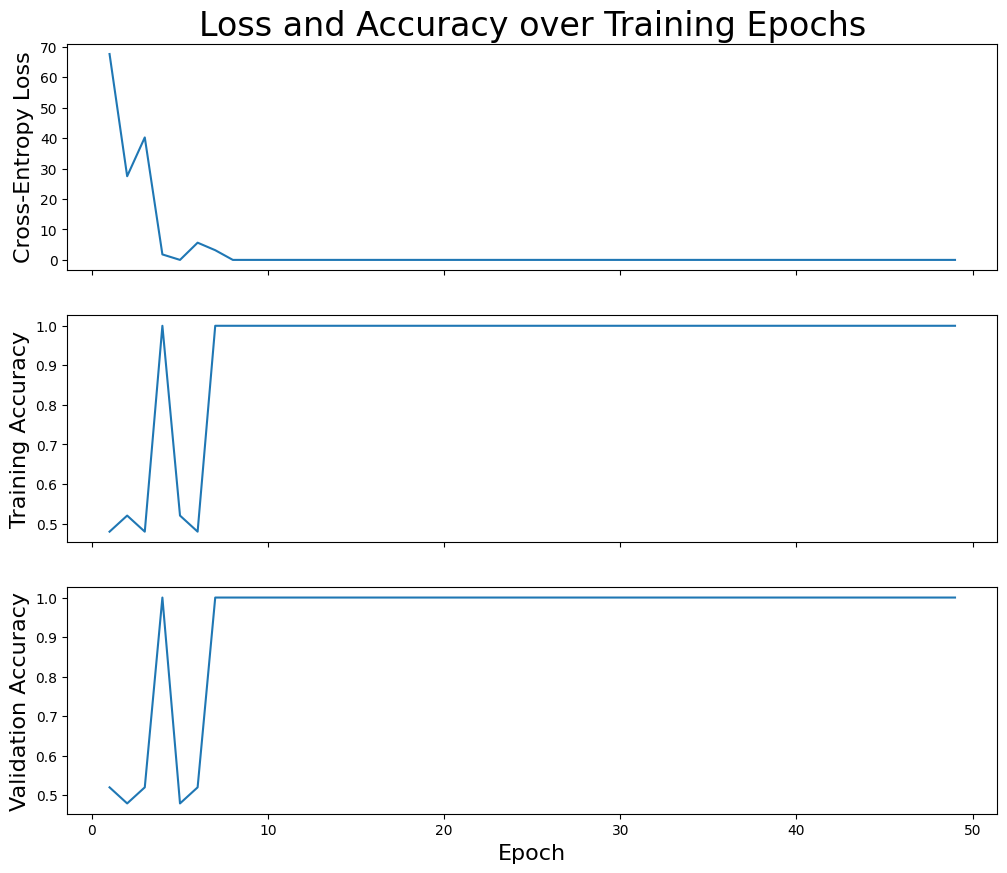

In [344]:
epochs = [e for e in range(1, num_epochs)]

# Plot loss and training/validation accuracy
f, axes = plt.subplots(3, 1, sharex=True, figsize=(12,10))

axes[0].plot(epochs, losses)
axes[0].set_ylabel("Cross-Entropy Loss", fontsize=16)
axes[1].plot(epochs, train_accs)
axes[1].set_ylabel("Training Accuracy", fontsize=16)
axes[2].plot(epochs, val_accs)
axes[2].set_ylabel("Validation Accuracy", fontsize=16)
axes[2].set_xlabel("Epoch", fontsize=16)
axes[0].set_title("Loss and Accuracy over Training Epochs", fontsize=24)

f.savefig("/content/train-loss-gnn.png", bbox_inches='tight')

In [345]:
# Save model to pt file
torch.save(model, "/content/gnn.pt")

In [346]:
graph = to_networkx(data)

In [347]:
# Print average training accuracy over all epochs
training_acc_avg = np.array(train_accs).mean()
val_acc_avg = np.array(val_accs).mean()
print(f"Average Training Accuracy ({num_epochs} epochs): {training_acc_avg}")
print(f"Average Validation Accuracy ({num_epochs} epochs): {val_acc_avg}")

Average Training Accuracy (50 epochs): 0.9485647903413189
Average Validation Accuracy (50 epochs): 0.9493943902910972


### Node Centrality

We'll want to calculate the centrality for the node types within our graph

In [348]:
import networkx
# used to check out centrality for non-site nodes
centralities = networkx.degree_centrality(graph) # G)
print(centralities)

node_centrality = pd.DataFrame().from_dict(centralities, orient="index", columns=["centrality"])
node_centrality['node_index'] = node_centrality.index.values
node_centrality.head()

{0: 0.4572790612394573, 1: 0.6600660066006601, 2: 0.29336266960029334, 3: 0.5925925925925926, 4: 0.0003667033370003667, 5: 0.0003667033370003667, 6: 0.0003667033370003667, 7: 0.0003667033370003667, 8: 0.0003667033370003667, 9: 0.0003667033370003667, 10: 0.0003667033370003667, 11: 0.0003667033370003667, 12: 0.0003667033370003667, 13: 0.004033736707004034, 14: 0.0003667033370003667, 15: 0.0003667033370003667, 16: 0.0003667033370003667, 17: 0.0003667033370003667, 18: 0.0003667033370003667, 19: 0.0003667033370003667, 20: 0.0003667033370003667, 21: 0.0003667033370003667, 22: 0.0003667033370003667, 23: 0.0003667033370003667, 24: 0.0003667033370003667, 25: 0.0003667033370003667, 26: 0.0003667033370003667, 27: 0.0003667033370003667, 28: 0.0003667033370003667, 29: 0.0003667033370003667, 30: 0.0003667033370003667, 31: 0.0003667033370003667, 32: 0.0003667033370003667, 33: 0.0003667033370003667, 34: 0.0003667033370003667, 35: 0.0003667033370003667, 36: 0.0003667033370003667, 37: 0.0003667033370003

,centrality,node_index
0,0.457279,0
1,0.660066,1
2,0.293363,2
3,0.592593,3
4,0.000367,4


In [349]:
### This is how you'll map centrality
node_offsets = pd.DataFrame.from_dict(data.node_offsets, orient="index")
node_offsets['node_index'] = node_offsets[0].astype(int)
node_offsets['node_type'] = node_offsets.index.values

max_index = node_offsets[0].max()

# Create a new DataFrame with expanded rows
node_indices = pd.DataFrame({
    'node_index': range(max_index + 1)
})

# Merge the expanded DataFrame with the original DataFrame
node_indices = node_indices.merge(node_offsets, on='node_index', how='left')#, right_index=True)

# Forward fill the missing values in the 'node_type' column
node_indices['node_type'] = node_indices['node_type'].fillna(method='ffill')

# Drop the 'node_index' column if needed
# node_indices.drop(columns=['node_index'], inplace=True)
node_indices = node_indices[['node_index', 'node_type']]
# Display the result
print(node_indices)

      node_index node_type
0              0      site
1              1      site
2              2      site
3              3      site
4              4  building
...          ...       ...
4959        4959  chemical
4960        4960  chemical
4961        4961  chemical
4962        4962  chemical
4963        4963  employee

[4964 rows x 2 columns]


In [350]:
# Join site type index with centrality
centrality = node_indices.merge(node_centrality, on="node_index", how="left")
centrality.head()

,node_index,node_type,centrality
0,0,site,0.457279
1,1,site,0.660066
2,2,site,0.293363
3,3,site,0.592593
4,4,building,0.000367


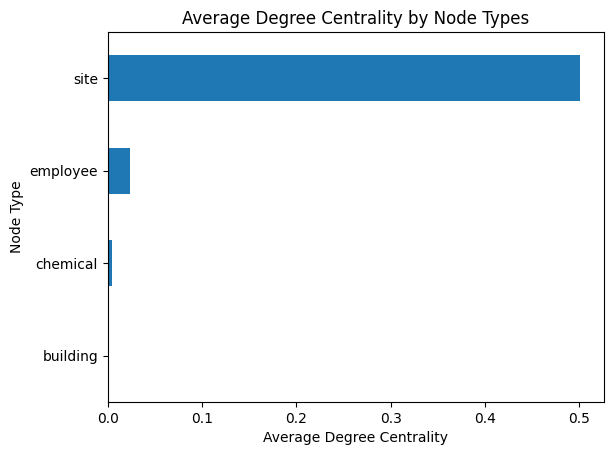

In [351]:
# Plot Avg centrality by node type
ax = centrality.groupby("node_type")['centrality'].mean().plot.barh()

ax.set_ylabel("Node Type")
ax.set_xlabel("Average Degree Centrality")
ax.set_title("Average Degree Centrality by Node Types")

ax.figure.savefig('node-centrality.png')

We can also leverage the [`Explainer` framework from PyG](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/explain.html#explaining-node-classification-on-a-heterogeneous-graph) to explain our Convolutional GNN

In [ ]:
from torch_geometric.explain import Explainer, CaptumExplainer


explainer = Explainer(
    model,  # It is assumed that model outputs a single tensor.
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config = dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='probs',  # Model returns probabilities.
    ),
)

# Generate batch-wise heterogeneous explanations for
# the nodes at index `1` and `3`:
hetero_explanation = explainer(
    data.x_dict,
    data.edge_index_dict,
    index=torch.tensor([1, 3]),
)
print(hetero_explanation.edge_mask_dict)
print(hetero_explanation.node_mask_dict)

In [ ]:
# Plot feature importance for GNN
feature_imp = hetero_explanation.visualize_feature_importance(top_k=10,
                                                              path="feature-importance.png")

plt.show()